In [2]:
pip install torch torchbnn numpy matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 83.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 59.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

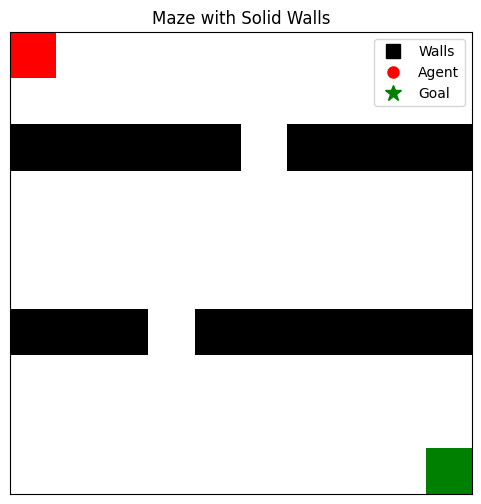

Episode 0: Steps=2830, Best=2830, Reward=-76.59
Episode 1: Steps=3412, Best=2830, Reward=-93.71
Episode 2: Steps=1154, Best=1154, Reward=-28.13
Episode 3: Steps=401, Best=401, Reward=-8.20
Episode 4: Steps=134, Best=134, Reward=-0.53
Episode 5: Steps=3987, Best=134, Reward=-97.06
Episode 6: Steps=1520, Best=134, Reward=-34.39
Episode 7: Steps=5922, Best=134, Reward=-156.41
Episode 8: Steps=6808, Best=134, Reward=-170.27
Episode 9: Steps=1592, Best=134, Reward=-43.11
Episode 10: Steps=1753, Best=134, Reward=-44.32
Episode 11: Steps=1659, Best=134, Reward=-42.38
Episode 12: Steps=320, Best=134, Reward=-5.19
Episode 13: Steps=145, Best=134, Reward=-0.24
Early stopping at episode 14 (no improvement for 10 episodes)


In [12]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchbnn as bnn
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from matplotlib import colors

# ===== CONSTANTS =====
# Maze configuration
MAZE_SIZE = 10
WALL_ROW_1 = 2
WALL_ROW_2 = 6
GAP_COL_1 = 5  # Gap in first wall
GAP_COL_2 = 3  # Gap in second wall
GOAL_POS = (MAZE_SIZE-1, MAZE_SIZE-1)  # Bottom-right corner
START_POS = (0, 0)  # Top-left corner

# Training parameters
MAX_EPISODES = 500
PATIENCE = 10  # Early stopping patience, after this number of episodes without improvement the training ends
PLOT_INTERVAL = 1  # Plot every N episodes
ANIMATION_INTERVAL = 300  # ms between frames

# Reward parameters
GOAL_REWARD = 1
STEP_PENALTY = -0.01
DISTANCE_REWARD_FACTOR = 0.1  # Scaling factor for distance-based reward

# Network parameters
LEARNING_RATE = 0.01
PRIOR_SIGMA = 0.1
HIDDEN_SIZE = 32

# ===== MAZE CLASS =====
class Maze:
    def __init__(self, size=MAZE_SIZE):
        self.size = size
        self.grid = np.zeros((size, size))
        self.goal = GOAL_POS
        self.walls = self._create_walls()
        self.reset()

    def _create_walls(self):
        """Create horizontal walls with specified gaps"""
        walls = set()
        # First horizontal wall with gap
        for y in range(self.size):
            if y != GAP_COL_1:
                walls.add((WALL_ROW_1, y))
        # Second horizontal wall with gap
        for y in range(self.size):
            if y != GAP_COL_2:
                walls.add((WALL_ROW_2, y))
        return walls

    def reset(self):
        self.agent_pos = START_POS
        return self.agent_pos

    def calculate_distance_to_goal(self, pos):
        """Calculate Manhattan distance to goal"""
        return abs(pos[0] - self.goal[0]) + abs(pos[1] - self.goal[1])

    def step(self, action):
        x, y = self.agent_pos
        new_x, new_y = x, y

        if action == 0 and x > 0:           new_x -= 1  # Up
        elif action == 1 and y < self.size-1: new_y += 1  # Right
        elif action == 2 and x < self.size-1: new_x += 1  # Down
        elif action == 3 and y > 0:           new_y -= 1  # Left

        # Check for wall collisions
        if (new_x, new_y) not in self.walls:
            prev_distance = self.calculate_distance_to_goal(self.agent_pos)
            self.agent_pos = (new_x, new_y)
            new_distance = self.calculate_distance_to_goal(self.agent_pos)
            distance_reward = (prev_distance - new_distance) * DISTANCE_REWARD_FACTOR
        else:
            distance_reward = -0.1  # Small penalty for hitting walls

        done = (self.agent_pos == self.goal)

        if done:
            reward = GOAL_REWARD
        else:
            reward = distance_reward + STEP_PENALTY

        return self.agent_pos, reward, done

    def render(self):
        """Visualize maze with solid walls using imshow"""
        # Create grid: 0=empty, 1=wall, 2=agent, 3=goal
        vis_grid = np.zeros((self.size, self.size))

        # Mark walls
        for (x, y) in self.walls:
            vis_grid[x, y] = 1

        # Mark agent and goal
        vis_grid[self.agent_pos] = 2
        vis_grid[self.goal] = 3

        # Create custom colormap
        cmap = colors.ListedColormap(['white', 'black', 'red', 'green'])
        bounds = [0, 1, 2, 3, 4]
        norm = colors.BoundaryNorm(bounds, cmap.N)

        plt.figure(figsize=(6,6))
        plt.imshow(vis_grid, cmap=cmap, norm=norm)

        # Add legend
        plt.plot([], [], 's', color='black', markersize=10, label='Walls')
        plt.plot([], [], 'o', color='red', markersize=8, label='Agent')
        plt.plot([], [], '*', color='green', markersize=12, label='Goal')
        plt.legend(loc='upper right')

        plt.title("Maze with Solid Walls")
        plt.xticks([])
        plt.yticks([])
        plt.show()

# ===== BAYESIAN DQN =====
class BayesianDQN(torch.nn.Module):
    def __init__(self, state_dim=2, action_dim=4):
        super().__init__()
        self.fc1 = bnn.BayesLinear(
            prior_mu=0,
            prior_sigma=PRIOR_SIGMA,
            in_features=state_dim,
            out_features=HIDDEN_SIZE
        )
        self.fc2 = bnn.BayesLinear(
            prior_mu=0,
            prior_sigma=PRIOR_SIGMA,
            in_features=HIDDEN_SIZE,
            out_features=action_dim
        )

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

# ===== TRAINING AND ANIMATION =====
def train_and_animate(maze, episodes=MAX_EPISODES, early_stop=True):
    model = BayesianDQN()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = bnn.BKLLoss(reduction='mean', last_layer_only=False)

    uncertainty_history = []
    episode_metrics = []
    best_steps = float('inf')
    no_improve = 0

    for ep in range(episodes):
        state = maze.reset()
        done = False
        steps = 0
        episode_reward = 0

        while not done:
            state_tensor = torch.FloatTensor(state)
            q_values = model(state_tensor)
            action = torch.argmax(q_values).item()
            next_state, reward, done = maze.step(action)

            episode_reward += reward

            # Calculate target with discount factor
            with torch.no_grad():
                if done:
                    target = torch.tensor(reward, dtype=torch.float32)
                else:
                    next_q_values = model(torch.FloatTensor(next_state))
                    target = reward + 0.99 * torch.max(next_q_values)

            # Calculate loss
            loss = torch.nn.MSELoss()(q_values[action], target) + criterion(model)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            steps += 1
            state = next_state

        if early_stop:
            if steps < best_steps:
                best_steps = steps
                no_improve = 0
            else:
                no_improve += 1

            if no_improve >= PATIENCE:
                print(f"Early stopping at episode {ep} (no improvement for {PATIENCE} episodes)")
                break

        if ep % PLOT_INTERVAL == 0:
            uncertainty_map = generate_uncertainty_map(model, maze)
            uncertainty_history.append(uncertainty_map)
            episode_metrics.append((ep, steps, best_steps, episode_reward))
            print(f"Episode {ep}: Steps={steps}, Best={best_steps}, Reward={episode_reward:.2f}")

    return create_animation(uncertainty_history, episode_metrics, maze)

def generate_uncertainty_map(model, maze):
    """Generate uncertainty map with walls marked as -1"""
    uncertainty_map = np.zeros((maze.size, maze.size))
    for x in range(maze.size):
        for y in range(maze.size):
            if (x, y) in maze.walls:
                uncertainty_map[x, y] = -1  # Special value for walls
            else:
                state = torch.FloatTensor([x, y])
                q_samples = [model(state).detach().numpy() for _ in range(10)]
                uncertainty_map[x, y] = np.std(q_samples, axis=0).mean()
    return uncertainty_map

def create_animation(uncertainty_history, episode_metrics, maze):
    """Create animation with solid walls"""
    fig, ax = plt.subplots(figsize=(8, 6))
    plt.close()

    # Create colormap for animation (walls will be black)
    cmap = plt.cm.hot.copy()
    cmap.set_bad('black')  # Walls shown as black

    # Initial plot
    masked_data = np.ma.masked_where(uncertainty_history[0] == -1, uncertainty_history[0])
    im = ax.imshow(masked_data, cmap=cmap, vmin=0, vmax=1)

    # Add static wall visualization
    wall_grid = np.zeros((maze.size, maze.size))
    for (x,y) in maze.walls:
        wall_grid[x,y] = 1
    ax.imshow(wall_grid, cmap=colors.ListedColormap(['none', 'black']), alpha=0.3)

    cbar = fig.colorbar(im, ax=ax, label='Uncertainty (Std Dev)')
    title = ax.set_title(f'Episode {episode_metrics[0][0]}\nSteps: {episode_metrics[0][1]}, Best: {episode_metrics[0][2]}, Reward: {episode_metrics[0][3]:.2f}')

    def update(frame):
        # Update uncertainty heatmap
        masked_data = np.ma.masked_where(uncertainty_history[frame] == -1, uncertainty_history[frame])
        im.set_array(masked_data)

        # Update title
        ep, steps, best, reward = episode_metrics[frame]
        title.set_text(f'Episode {ep}\nSteps: {steps}, Best: {best}, Reward: {reward:.2f}')

        return im, title

    ani = FuncAnimation(
        fig,
        update,
        frames=len(uncertainty_history),
        interval=ANIMATION_INTERVAL,
        blit=False
    )

    return HTML(ani.to_jshtml())

# ===== MAIN =====
if __name__ == "__main__":
    maze = Maze()
    maze.render()  # Show initial maze with solid walls
    animation = train_and_animate(maze)
    display(animation)

In [ ]:
# In scripts: Use ani.save('uncertainty_evolution.mp4')